In [1]:
pip install numpy opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [3]:
import os

folder_path = 'posters'
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Total de imágenes encontradas: {len(image_files)}")


Total de imágenes encontradas: 29066


Extracción de características con RGB + LPB

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize

# Ruta a la carpeta con las imágenes
folder_path = 'posters'

# Configuración de LBP
radius = 1
n_points = 8 * radius

# Listas para guardar resultados
features = []
filenames = []

# Filtrar solo imágenes
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for filename in image_files:
    try:
        path = os.path.join(folder_path, filename)
        image = imread(path)
        image_resized = resize(image, (128, 128))
        gray = rgb2gray(image_resized)

        # Histograma RGB
        hist_rgb = np.concatenate([
            np.histogram(image_resized[:, :, i], bins=16, range=(0, 1), density=True)[0]
            for i in range(3)
        ])

        # LBP
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        lbp_hist, _ = np.histogram(
            lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2), density=True
        )

        # Concatenar vectores
        vector = np.concatenate([hist_rgb, lbp_hist])
        features.append(vector)
        filenames.append(filename)

    except Exception as e:
        print(f"Error con {filename}: {e}")

# Guardar en CSV
df_features = pd.DataFrame(features)
df_features['filename'] = filenames
df_features.to_csv('features_all_rgb_lbp.csv', index=False)

print(f"Características RGB + LBP extraídas para {len(df_features)} imágenes.")


PCA (2 componentes) sobre características RGB + LBP


In [11]:
import pandas as pd
import numpy as np

# Cargar el archivo
df = pd.read_csv('features_all_rgb_lbp.csv')

# Separar características (excluye la columna 'filename')
X = df.select_dtypes(include=[np.number]).values

# Centrar los datos (restar la media)
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

# Calcular la matriz de covarianza
cov_matrix = np.cov(X_centered, rowvar=False)

# Calcular autovalores y autovectores
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Ordenar de mayor a menor según autovalores
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Seleccionar los 2 componentes principales
components = eigenvectors[:, :2]

# Transformar los datos
X_pca = np.dot(X_centered, components)

# Varianza explicada
total_var = np.sum(eigenvalues)
explained_var_ratio = eigenvalues[:2] / total_var

print(f"Varianza explicada total (2 componentes): {np.sum(explained_var_ratio):.4f}")


Varianza explicada total (2 componentes): 0.6033


K-Means con k=3

In [12]:
import numpy as np
import pandas as pd

def kmeans_manual(X, k=3, max_iters=100):
    # Inicialización: selecciona k puntos aleatorios como centroides
    np.random.seed(42)
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]

    for _ in range(max_iters):
        # Asignar cada punto al cluster más cercano
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Recalcular centroides
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)])

        # Verificar convergencia
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return labels, centroids

#  K-Means 
labels_kmeans, centroids = kmeans_manual(X_pca, k=3)

#  Silhouette Score  
def silhouette_manual(X, labels):
    silhouette_values = []
    for i in range(len(X)):
        same_cluster = X[labels == labels[i]]
        other_clusters = [X[labels == l] for l in set(labels) if l != labels[i]]

        if len(same_cluster) > 1:
            a = np.mean(np.linalg.norm(X[i] - same_cluster, axis=1))
            b = min([np.mean(np.linalg.norm(X[i] - c, axis=1)) for c in other_clusters]) if other_clusters else 0
            s = (b - a) / max(a, b) if max(a, b) > 0 else 0
            silhouette_values.append(s)
        else:
            silhouette_values.append(0)
    return np.mean(silhouette_values)

#  Calinski-Harabasz Index  
def calinski_harabasz_manual(X, labels, centroids):
    k = len(np.unique(labels))
    n = len(X)
    overall_mean = X.mean(axis=0)
    ssb = sum(len(X[labels == i]) * np.linalg.norm(centroids[i] - overall_mean) ** 2 for i in range(k))
    ssw = sum(np.linalg.norm(X[labels == i] - centroids[i], axis=1).sum() for i in range(k))
    return (ssb / (k - 1)) / (ssw / (n - k)) if n > k else 0

#  Davies-Bouldin Index  
def davies_bouldin_manual(X, labels, centroids):
    k = len(np.unique(labels))
    cluster_dists = [np.mean(np.linalg.norm(X[labels == i] - centroids[i], axis=1)) for i in range(k)]
    db_index = 0
    for i in range(k):
        max_r = 0
        for j in range(k):
            if i != j:
                r = (cluster_dists[i] + cluster_dists[j]) / np.linalg.norm(centroids[i] - centroids[j])
                max_r = max(max_r, r)
        db_index += max_r
    return db_index / k

#  Calcular métricas 
sil = silhouette_manual(X_pca, labels_kmeans)
calinski = calinski_harabasz_manual(X_pca, labels_kmeans, centroids)
davies = davies_bouldin_manual(X_pca, labels_kmeans, centroids)

#  Mostrar resultados 
print("\nMÉTRICAS CON TODAS LAS IMÁGENES (manual K-Means + PCA):")
print(f"Clusters formados: {len(set(labels_kmeans))}")
print(f"Silhouette Score: {sil:.4f}")
print(f"Calinski-Harabasz Index: {calinski:.2f}")
print(f"Davies-Bouldin Index: {davies:.4f}")



MÉTRICAS CON TODAS LAS IMÁGENES (manual K-Means + PCA):
Clusters formados: 3
Silhouette Score: 0.5143
Calinski-Harabasz Index: 142326.02
Davies-Bouldin Index: 0.6518


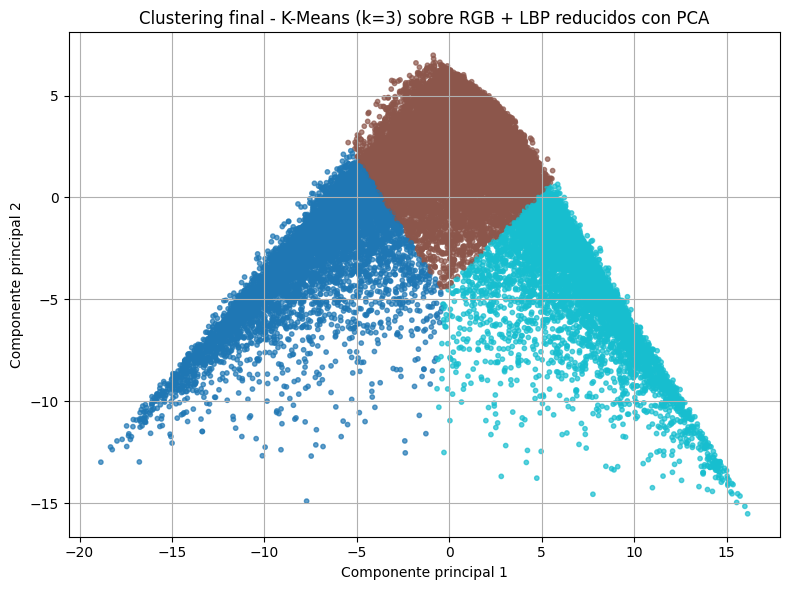

In [13]:
import matplotlib.pyplot as plt

# Graficar clustering
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='tab10', s=10, alpha=0.7)
plt.title("Clustering final - K-Means (k=3) sobre RGB + LBP reducidos con PCA")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import csv
import math
import random

# === 1. Leer CSV y cargar datos ===
filename_col = 'filename'
numeric_cols = []
data = []
movie_ids = []

with open('features_all_rgb_lbp.csv', 'r', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    headers = reader.fieldnames

    numeric_cols = [h for h in headers if h != filename_col]

    for row in reader:
        movie_id = int(row[filename_col].replace('.jpg', ''))
        movie_ids.append(movie_id)
        features = [float(row[col]) for col in numeric_cols]
        data.append(features)

# === 2. Calcular media por columna ===
def mean_column(data, col_index):
    return sum(row[col_index] for row in data) / len(data)

means = [mean_column(data, i) for i in range(len(numeric_cols))]
centered_data = [[row[i] - means[i] for i in range(len(numeric_cols))] for row in data]

# === 3. PCA (2 componentes manual) ===
def transpose(matrix):
    return list(map(list, zip(*matrix)))

def dot_product(vec1, vec2):
    return sum(a * b for a, b in zip(vec1, vec2))

def matrix_multiply(A, B):
    return [[dot_product(row, col) for col in transpose(B)] for row in A]

def normalize(vec):
    norm = math.sqrt(sum(v ** 2 for v in vec))
    return [v / norm for v in vec]

def project(data, component):
    return [[dot_product(row, component)] for row in data]

def pca_first_two_components(data):
    trans_data = transpose(data)
    cov = matrix_multiply(trans_data, data)

    def power_iteration(matrix, num_iters=100):
        b_k = [1.0] * len(matrix)
        for _ in range(num_iters):
            b_k1 = [sum(matrix[i][j] * b_k[j] for j in range(len(matrix))) for i in range(len(matrix))]
            norm = math.sqrt(sum(x ** 2 for x in b_k1))
            b_k = [x / norm for x in b_k1]
        return b_k

    pc1 = normalize(power_iteration(cov))
    proj1 = project(data, pc1)

    def subtract_component(data, component):
        return [
            [val - dot_product(row, component) * component[i] for i, val in enumerate(row)]
            for row in data
        ]

    residual_data = subtract_component(data, pc1)
    cov2 = matrix_multiply(transpose(residual_data), residual_data)
    pc2 = normalize(power_iteration(cov2))
    proj2 = project(data, pc2)

    return [[p1[0], p2[0]] for p1, p2 in zip(proj1, proj2)]

X_pca = pca_first_two_components(centered_data)

# === 4. Elegir queries aleatorios ===
random.seed(42)
query_indices = random.sample(range(len(data)), 2923)

# === 5. Calcular distancias y recomendaciones ===
def euclidean(vec1, vec2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(vec1, vec2)))

submission_rows = []

for idx in query_indices:
    query_id = movie_ids[idx]
    query_vec = X_pca[idx]

    dists = []
    for i, vec in enumerate(X_pca):
        if i == idx:
            dists.append((float('inf'), i))
        else:
            dist = euclidean(query_vec, vec)
            dists.append((dist, i))

    top_indices = sorted(dists)[:10]

    for pos, (_, rec_idx) in enumerate(top_indices):
        rec_id = movie_ids[rec_idx]
        submission_rows.append({
            'ID': f"{query_id}_{pos+1}",
            'query_movie_id': query_id,
            'recommended_movie_id': rec_id,
            'position': pos + 1
        })

# === 6. Guardar resultados en CSV ===
with open('submission.csv', 'w', newline='') as csvfile:
    fieldnames = ['ID', 'query_movie_id', 'recommended_movie_id', 'position']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in submission_rows:
        writer.writerow(row)

print("Archivo submission.csv generado.")
